In [1]:
# scratch code to get atmsopheric forcing .nc files

from datetime import datetime

import sys
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage
import xarray as xr
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator


In [2]:
# a function that loads up the roms grid as a dict

def roms_grid_to_dict(fng):
    gr = nc.Dataset(fng)    
    # get roms grid variables
    RM=dict()
    RM['lon_rho']=gr.variables['lon_rho'][:,:]
    RM['lat_rho']=gr.variables['lat_rho'][:,:]
    RM['lon_u']=gr.variables['lon_u'][:,:]
    RM['lat_u']=gr.variables['lat_u'][:,:]
    RM['lon_v']=gr.variables['lon_v'][:,:]
    RM['lat_v']=gr.variables['lat_v'][:,:]
    RM['h'] =gr.variables['h'][:,:]
    RM['mask_rho'] = gr.variables['mask_rho'][:,:]
    RM['mask_u'] = gr.variables['mask_u'][:,:]
    RM['mask_v'] = gr.variables['mask_v'][:,:]
    RM['angle'] = gr.variables['angle'][:,:]
    RM['angle_u'] = 0.5*(RM['angle'][:,0:-1]+RM['angle'][:,1:])
    RM['angle_v'] = 0.5*(RM['angle'][0:-1,:]+RM['angle'][1:,:])
    return RM


In [3]:
def get_atm_data_as_dict(yyyymmdd,run_type,atm_mod,get_method):
    from datetime import datetime
    from pydap.client import open_url
    import pygrib

    
    # this function will returm ATM, a dict of all atmospheric fields ROMS requires
    # keys will be the ROMS .nc variable names.
    # they will be on the atm grid (not roms grid)
    # the forecast data will start at yyyymmdd and 000z. All times of the forecast will
    # be returned. atm_mod is the type of atm models used, one of:
    # 'nams_nest', 'nam_1hr', or 'hrrr', or 'gfs'
    # get_method, is the type of method used, either 'open_dap' or 'grib_download'

    # the code in here goes from the start date to all forecast dates
    #d1=datetime(2024,6,17) # a datetime object, the date is the date of forecast
    def get_roms_times(fore_date,t,t_ref):
        # this funtion returns times past t_ref in days
        # consistent with how ROMS likes it
        from datetime import datetime, timedelta

        d1=datetime.fromisoformat(fore_date)
        t2 = t-t[0] # an ndarray of days, t is from atm import
        t3 = d1 + t2 * timedelta(days=1)
        # t3 looks good and is the correct time stamps of the forecast.
        # But for ROMS we need ocean_time which is relative to 1970,1,1. 
        # in seconds. So...
        tr = t3 - t_ref
        tr_days = tr.astype("timedelta64[ms]").astype(float) / 1000 / 3600 / 24
        # tr_sec is now an ndarray of days past the reference day
        return tr_days

    if get_method == 'open_dap' and run_type == 'forecast':
        # using opendap to get nomads data using pydap
        # with this method the data is not downloaded directly, initially
        # and the data is rectilinear, lon and lat are both vectors

        # nam_nest is at 3 hr resolution, for 2.5 days
        # 0.03 deg horizontal resolution
        nam_nest = 'https://nomads.ncep.noaa.gov/dods/nam/nam' + yyyymmdd + '/nam_conusnest_00z'

        # nam_1hr is at 1 hr resolution, for 1.5 days
        # 0.11 deg horizontal resolution
        nam_1hr = 'https://nomads.ncep.noaa.gov/dods/nam/nam' + yyyymmdd + '/nam1hr_00z'

        # hires_fv3 is at 1 hr resolution, for 2.5 days
        # 0.05 deg horizontal resolution
        # this one doesn't have short and long wave. DARN. DONT USE!!!!
        # hires_fv3 = 'https://nomads.ncep.noaa.gov/dods/hiresw/hiresw' + yyyymmdd + '/hiresw_conusfv3_00z'

        # hrrr is at 1 hr resolution, for 2 days, for 00z forecast
        # 0.03 deg horizontal resolution 
        # this is clearly the highest resolution product
        hrrr = 'https://nomads.ncep.noaa.gov/dods/hrrr/hrrr' + yyyymmdd + '/hrrr_sfc.t00z'

        # gfs is at 1 hr resolution, for 5 days
        # 0.25 deg horizontal resolution
        gfs = 'https://nomads.ncep.noaa.gov/dods/gfs_0p25_1hr/gfs' + yyyymmdd + '/gfs_0p25_1hr_00z'

        if atm_mod == 'nam_nest':
            atm_name = nam_nest
        if atm_mod == 'nam_1hr':
            atm_name = nam_1hr
        #if atm_mod == 'hires_fv3':
        #    atm_name = hires_fv3
        if atm_mod == 'hrrr':
            atm_name = hrrr
        if atm_mod == 'gfs':
            atm_name = gfs

        # open a connection to the opendap server. This could be made more robust? 
        # by trying repeatedly?
        # open_url is sometimes slow, and this block of code can be fast (1s), med (6s), or slow (>15s)
        dataset = open_url(atm_name)

        time = dataset['time']         # ???
        ln   = dataset['lon']          # deg
        lt   = dataset['lat']          # deg
        #Pres = dataset['pressfc']      # at surface, pa
        Pres = dataset['prmslmsl']     # pressure reduced to mean sea level.
        Temp = dataset['tmpsfc']       # at surface, K
        Hum  = dataset['rh2m']         # at 2 meters, %
        U    = dataset['ugrd10m']      # at 10 meters, m/s
        V    = dataset['vgrd10m']      # at 10 meters, m/s
        if atm_name == nam_nest or atm_name == hrrr:
            Rain = dataset['pratesfc'] # at surface, kg/m2/s
        if atm_name == nam_1hr:        # or atm_name == hires_fv3
            Rain = dataset['apcpsfc']  # total precip, kg/m2, need to take diffs of times.    
        Swd  = dataset['dswrfsfc']     # downward short-wave at surface, W/m2
        Swu  = dataset['uswrfsfc']     # upward short-wave at surface, W/m2
        Lwd  = dataset['dlwrfsfc']     # downward long-wave at surface, W/m2
        Lwu  = dataset['ulwrfsfc']     # upward long-wave at surface, W/m2

        # here we find the indices of the data we want for LV1
        ln_min = -124.5
        ln_max = -115
        lt_min = 28
        lt_max = 37
        Ln0    = ln[:]
        Lt0    = lt[:]
        iln    = np.where( (Ln0>=ln_min)*(Ln0<=ln_max) ) # the lon indices where we want data
        ilt    = np.where( (Lt0>=lt_min)*(Lt0<=lt_max) ) # the lat indices where we want data

       
        # now time to get the numbers that we want. I get them as arrays?
        pres2 = Pres[:,ilt[0][0]:ilt[0][-1],iln[0][0]:iln[0][-1]] # indexing looks bad but works
        t     = pres2.time[:].data
        # return the roms times past tref in days
        t_ref = datetime(1970,1,1)
        t_rom = get_roms_times(yyyymmdd,t,t_ref)
        lon   = pres2.lon[:].data
        lat   = pres2.lat[:].data
        pres  = pres2.array[:,:,:].data

        # we will get the other data directly
        temp = Temp.array[:,ilt[0][0]:ilt[0][-1],iln[0][0]:iln[0][-1]].data
        hum  =  Hum.array[:,ilt[0][0]:ilt[0][-1],iln[0][0]:iln[0][-1]].data
        u    =    U.array[:,ilt[0][0]:ilt[0][-1],iln[0][0]:iln[0][-1]].data
        v    =    V.array[:,ilt[0][0]:ilt[0][-1],iln[0][0]:iln[0][-1]].data
        rain = Rain.array[:,ilt[0][0]:ilt[0][-1],iln[0][0]:iln[0][-1]].data
        swd  =  Swd.array[:,ilt[0][0]:ilt[0][-1],iln[0][0]:iln[0][-1]].data
        swu  =  Swu.array[:,ilt[0][0]:ilt[0][-1],iln[0][0]:iln[0][-1]].data
        lwd  =  Lwd.array[:,ilt[0][0]:ilt[0][-1],iln[0][0]:iln[0][-1]].data
        lwu  =  Lwu.array[:,ilt[0][0]:ilt[0][-1],iln[0][0]:iln[0][-1]].data
        # I think everything is an np.ndarray ?

        # set up dict and fill in
        ATM = dict()
        ATM['lon']=lon
        ATM['lat']=lat
        ATM['ocean_time'] = t_rom
        ATM['ocean_time_ref'] = t_ref
        ATM['lwrad'] = lwd-lwu
        ATM['lwrad_down'] = lwd
        ATM['swrad'] = swd-swu
        ATM['rain'] = rain
        ATM['Tair'] = temp - 273.15 # convert from K to C
        ATM['Pair'] = 0.01 * pres   # convert from Pa to db
        ATM['Qair'] = hum
        ATM['Uwind'] = u
        ATM['Vwind'] = v

        # put the units in atm...
        units = dict()
        units['lon'] = 'degrees_east'
        units['lat'] = 'degrees_north'
        units['ocean_time'] = 'days'
        units['ocean_time_ref'] = 'python datetime'
        units['lwrad'] 


    return ATM

In [99]:
def get_atm_data_on_roms_grid(ATM,RMG):

    field_names = ['lwrad', 'lwrad_down', 'swrad', 'rain', 'Tair', 'Pair', 'Qair', 'Uwind', 'Vwind']
    # dimensions of all fields are [ntime,nlat,nlon]
    
    t = ATM['ocean_time']
    nt = len(t)
    lon = ATM['lon']
    lat = ATM['lat']
    Lt_r = RMG['lat_rho']
    Ln_r = RMG['lon_rho']
    nlt,nln = np.shape(Lt_r)

    got_F = 0
    

    atm2 = dict()

    for a in field_names:
        print(a)
        f1 = ATM[a]
        frm2 = np.zeros( (nt,nlt,nln) ) # need to initialize the dict, or there are problems
        atm2[a] = frm2

        for b in range(nt):
            f2 = np.squeeze( f1[b,:,:] )

            if got_F == 0:
                F = RegularGridInterpolator((lat,lon),f2)
                got_F = 1
            else:                
                setattr(F,'values',f2)

            froms = F((Lt_r,Ln_r),method='linear')
            atm2[a][b,:,:] = froms
            #frm2[b,:,:] = froms
        
        #atm2[a]=frm2

    atm2['lat'] = RMG['lat_rho']
    atm2['lon'] = RMG['lon_rho']
    atm2['ocean_time'] = ATM['ocean_time']
    atm2['ocean_time_ref'] = ATM['ocen_time_ref']
    atm2['ocean_time_units'] = ATM['ocean_time_units']
    # atm2 is now on the roms grid. but we need to rotate the winds from N-S, E-W to ROMS (xi,eta)
    angr = RMG['angle']
    cosang = np.cos(angr)
    sinang = np.sin(angr)
    Cosang = np.tile(cosang,(nt,1,1))
    Sinang = np.tile(sinang,(nt,1,1))
    ur = Cosang * atm2['Uwind'] + Sinang * atm2['Vwind']
    vr = Cosang * atm2['Vwind'] - Sinang * atm2['Uwind']
 
    atm2['Uwind'] = ur
    atm2['Vwind'] = vr
        
    return atm2

In [5]:
# use the get_atm_data function!!!
# atm data is on atm grid, velocities are E-W / N-S
yyyymmdd='20240620'
run_type = 'forecast'
atm_mod = 'nam_nest'
get_method = 'open_dap'

ATM = get_atm_data_as_dict(yyyymmdd,run_type,atm_mod,get_method)


In [100]:
# get the ROMS grid
fngr = '/Users/mspydell/research/FF2024/models/SDPM_mss/PFM_user/grids/GRID_SDTJRE_LV1.nc'
RMG = roms_grid_to_dict(fngr)

# put the atm data on the roms grid, and rotate the velocities
# everything in this dict turn into the atm.nc file
ATM_R  = get_atm_data_on_roms_grid(ATM,RMG)


lwrad
lwrad_down
swrad
rain
Tair
Pair
Qair
Uwind
Vwind


In [13]:
print( np.shape(ATM_R['Uwind']) )
print( np.shape(ATM_R['Vwind']) )
print( np.shape(ATM_R['lat']) )
print( np.shape(ATM_R['lon']) )

(21, 390, 253)
(21, 390, 253)
(390, 253)
(390, 253)


In [9]:
def plot_roms_box(axx,RMG):
    xr1 = RMG['lon_rho'][0,:]
    yr1 = RMG['lat_rho'][0,:]
    xr2 = RMG['lon_rho'][:,0]
    yr2 = RMG['lat_rho'][:,0]
    xr3 = RMG['lon_rho'][-1,:]
    yr3 = RMG['lat_rho'][-1,:]
    xr4 = RMG['lon_rho'][:,-1]
    yr4 = RMG['lat_rho'][:,-1]
    axx.plot(xr1,yr1,'k-',linewidth=.5)
    axx.plot(xr2,yr2,'k-',linewidth=.5)
    axx.plot(xr3,yr3,'k-',linewidth=.5)
    axx.plot(xr4,yr4,'k-',linewidth=.5)

def plot_roms_coastline(axx,RMG):
    axx.contour(RMG['lon_rho'],RMG['lat_rho'],RMG['h'],levels=[5, 10],colors='k')

Text(0.5, 1.0, 'ROMS Vwind')

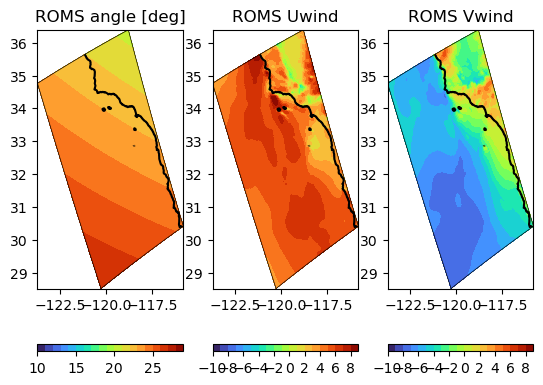

In [97]:
fig, axs = plt.subplots(nrows=1, ncols=3)
cmap=plt.get_cmap('turbo')
plt.set_cmap(cmap)
plevs=np.arange(10,30,1)
plevs2=np.arange(10,30,5)
cset1=axs[0].contourf(RMG['lon_rho'],RMG['lat_rho'],180/math.pi*RMG['angle'],plevs)
plot_roms_box(axs[0],RMG)
plot_roms_coastline(axs[0],RMG)
cbar=fig.colorbar(cset1,ax=axs[0],orientation='horizontal')
cbar.set_ticks(plevs2)
axs[0].set_title('ROMS angle [deg]')

plevs=np.arange(-10,10,1)
plevs2=np.arange(-10,10,2)
cset1=axs[1].contourf(ATM_R['lon'],ATM_R['lat'],ATM_R['Uwind'][0,:,:],plevs)
plot_roms_box(axs[1],RMG)
plot_roms_coastline(axs[1],RMG)
cbar=fig.colorbar(cset1,ax=axs[1],orientation='horizontal')
cbar.set_ticks(plevs2)
axs[1].set_title('ROMS Uwind')

cset1=axs[2].contourf(ATM_R['lon'],ATM_R['lat'],ATM_R['Vwind'][0,:,:],plevs)
plot_roms_box(axs[2],RMG)
plot_roms_coastline(axs[2],RMG)
cbar=fig.colorbar(cset1,ax=axs[2],orientation='horizontal')
cbar.set_ticks(plevs2)
axs[2].set_title('ROMS Vwind')


Text(0.5, 1.0, '10 m velocity [m/s, on RM grid]')

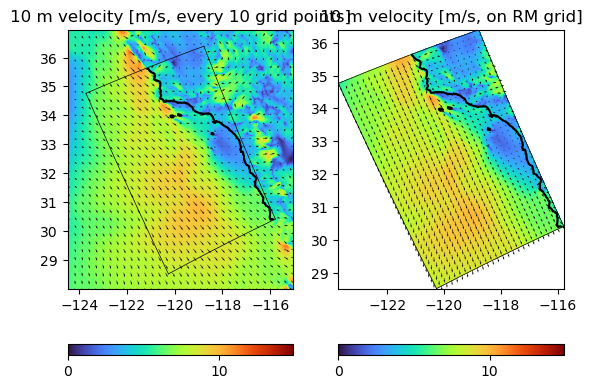

In [102]:
#velocity plot
fig, axs = plt.subplots(nrows=1, ncols=2)


plevs=np.arange(0,15,.1)
cmap=plt.get_cmap('turbo')
plt.set_cmap(cmap)
cset1=axs[0].contourf(ATM['lon'],ATM['lat'],(ATM['Uwind'][0,:,:]**2 +ATM['Vwind'][0,:,:]**2)**0.5,plevs)
plot_roms_box(axs[0],RMG)
plot_roms_coastline(axs[0],RMG)
axs[0].quiver(ATM['lon'][0:-1:10],ATM['lat'][0:-1:10],ATM['Uwind'][0,0:-1:10,0:-1:10],ATM['Vwind'][0,0:-1:10,0:-1:10])
#axs[0].quiver(-123,31,7,-7,color='w') direction looks right
cbar=fig.colorbar(cset1,ax=axs[0],orientation='horizontal')
cbar.set_ticks(np.arange(0,20,10))
axs[0].set_title('10 m velocity [m/s, every 10 grid points]')

plt.set_cmap(cmap)
plevs=np.arange(0,15,.1)
cset1=axs[1].contourf(ATM_R['lon'],ATM_R['lat'],(ATM_R['Uwind'][0,:,:]**2 + ATM_R['Vwind'][0,:,:]**2)**0.5,plevs)
#cset1=axs[1].contourf(ATM_R['lon'],ATM_R['lat'],(ATM_R['Vwind'][0,:,:]**2 + ATM_R['Uwind'][0,:,:]**2)**0.5,plevs)
plot_roms_box(axs[1],RMG)
plot_roms_coastline(axs[1],RMG)
axs[1].quiver(ATM_R['lon'][0:-1:10,0:-1:10],ATM_R['lat'][0:-1:10,0:-1:10],ATM_R['Uwind'][0,0:-1:10,0:-1:10],ATM_R['Vwind'][0,0:-1:10,0:-1:10])
#axs[0].quiver(-123,31,7,-7,color='w') direction looks right
cbar=fig.colorbar(cset1,ax=axs[1],orientation='horizontal')
cbar.set_ticks(np.arange(0,20,10))
axs[1].set_title('10 m velocity [m/s, on RM grid]')


Text(0.5, 1.0, 'ATM Vwind')

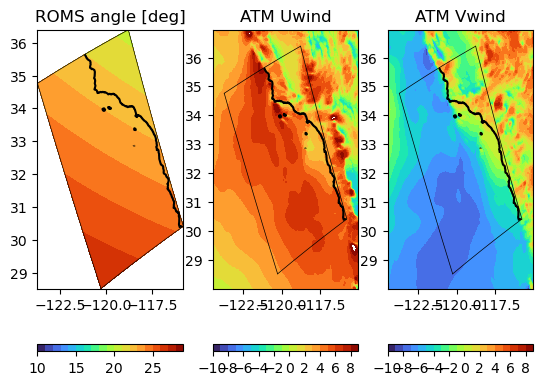

In [28]:
# check lwup and lwdown
import math
fig, axs = plt.subplots(nrows=1, ncols=3)
cmap=plt.get_cmap('turbo')
plt.set_cmap(cmap)
plevs=np.arange(10,30,1)
plevs2=np.arange(10,30,5)
cset1=axs[0].contourf(RMG['lon_rho'],RMG['lat_rho'],180/math.pi*RMG['angle'],plevs)
plot_roms_box(axs[0],RMG)
plot_roms_coastline(axs[0],RMG)
cbar=fig.colorbar(cset1,ax=axs[0],orientation='horizontal')
cbar.set_ticks(plevs2)
axs[0].set_title('ROMS angle [deg]')

plevs=np.arange(-10,10,1)
plevs2=np.arange(-10,10,2)
cset1=axs[1].contourf(ATM['lon'],ATM['lat'],ATM['Uwind'][0,:,:],plevs)
plot_roms_box(axs[1],RMG)
plot_roms_coastline(axs[1],RMG)
cbar=fig.colorbar(cset1,ax=axs[1],orientation='horizontal')
cbar.set_ticks(plevs2)
axs[1].set_title('ATM Uwind')

plevs=np.arange(-10,10,1)
plevs2=np.arange(-10,10,2)
cset1=axs[2].contourf(ATM['lon'],ATM['lat'],ATM['Vwind'][0,:,:],plevs)
plot_roms_box(axs[2],RMG)
plot_roms_coastline(axs[2],RMG)
cbar=fig.colorbar(cset1,ax=axs[2],orientation='horizontal')
cbar.set_ticks(plevs2)
axs[2].set_title('ATM Vwind')


Text(0.5, 1.0, 'approx ROMS Vwind')

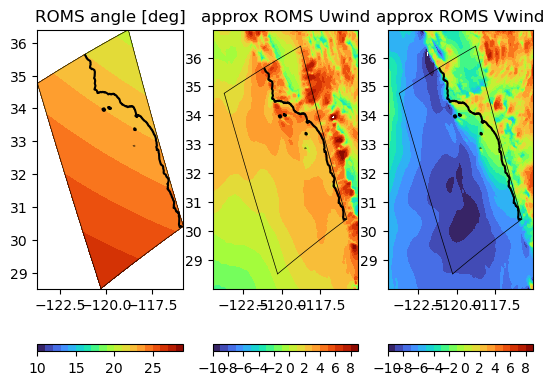

In [29]:

fig, axs = plt.subplots(nrows=1, ncols=3)
cmap=plt.get_cmap('turbo')
plt.set_cmap(cmap)
plevs=np.arange(10,30,1)
plevs2=np.arange(10,30,5)
cset1=axs[0].contourf(RMG['lon_rho'],RMG['lat_rho'],180/math.pi*RMG['angle'],plevs)
plot_roms_box(axs[0],RMG)
plot_roms_coastline(axs[0],RMG)
cbar=fig.colorbar(cset1,ax=axs[0],orientation='horizontal')
cbar.set_ticks(plevs2)
axs[0].set_title('ROMS angle [deg]')

plevs=np.arange(-10,10,1)
plevs2=np.arange(-10,10,2)
cset1=axs[1].contourf(ATM['lon'],ATM['lat'],np.cos(25/180*math.pi)*ATM['Uwind'][0,:,:]+np.sin(25/180*math.pi)*ATM['Vwind'][0,:,:],plevs)
plot_roms_box(axs[1],RMG)
plot_roms_coastline(axs[1],RMG)
cbar=fig.colorbar(cset1,ax=axs[1],orientation='horizontal')
cbar.set_ticks(plevs2)
axs[1].set_title('approxROMS Uwind')

plevs=np.arange(-10,10,1)
plevs2=np.arange(-10,10,2)
cset1=axs[2].contourf(ATM['lon'],ATM['lat'],-np.sin(25/180*math.pi)*ATM['Uwind'][0,:,:]+np.cos(25/180*math.pi)*ATM['Vwind'][0,:,:],plevs)
plot_roms_box(axs[2],RMG)
plot_roms_coastline(axs[2],RMG)
cbar=fig.colorbar(cset1,ax=axs[2],orientation='horizontal')
cbar.set_ticks(plevs2)
axs[2].set_title('approx ROMS Vwind')


In [137]:
# ATM_R is the dict of atmospheric variables on the roms grid
# get this information into an xr.Dataset object

vinfo=dict()
vinfo['lon'] = {'long_name':'longitude',
                 'units':'degrees_east'}
vinfo['lat'] = {'long_name':'latitude',
                 'units':'degrees_north'}
vinfo['ocean_time'] = {'long_name':'atmospheric forcing time',
                       'units':'days since tref'}
vinfo['Tair'] = {'long_name':'surface air temperature',
                 'units':'degrees C',
                 'coordinates':'lat,lon',
                 'time':'ocean_time'}
vinfo['Pair'] = {'long_name':'surface air pressure',
                 'units':'mb',
                 'coordinates':'lat,lon',
                 'time':'ocean_time'}
vinfo['Qair'] = {'long_name':'surface air relative humidity',
                 'units':'percent [%]',
                 'coordinates':'lat,lon',
                 'time':'ocean_time'}
vinfo['rain'] = {'long_name':'precipitation rate',
                 'units':'kg/m^2/s',
                 'coordinates':'lat,lon',
                 'time':'ocean_time'}
vinfo['swrad'] = {'long_name':'net solar short wave radiation flux down',
                 'units':'W/m^2',
                 'coordinates':'lat,lon',
                 'time':'ocean_time',
                 'negative values': 'upward flux, cooling',
                 'positive values': 'downward flux, warming'}
vinfo['lwrad'] = {'long_name':'net solar long wave radiation flux down',
                 'units':'W/m^2',
                 'coordinates':'lat,lon',
                 'time':'ocean_time',
                 'negative values': 'upward flux, cooling',
                 'positive values': 'downward flux, warming'}
vinfo['lwrad_down'] = {'long_name':'solar long wave down radiation flux',
                 'units':'W/m^2',
                 'coordinates':'lat,lon',
                 'time':'ocean_time',
                 'note' : 'this is the downward component of the flux, warming'}
vinfo['Uwind'] = {'long_name':'roms east coordinate, er, velocity',
                 'units':'m/s',
                 'coordinates':'lat,lon',
                 'time':'ocean_time',
                 'note':'these velocity velocities are in ROMS coordinate'}
vinfo['Vwind'] = {'long_name':'roms north coordinate, xi, velocity',
                 'units':'m/s',
                 'coordinates':'lat,lon',
                 'time':'ocean_time',
                 'note':'these velocity velocities are in ROMS coordinate'}


ds = xr.Dataset(
    data_vars = dict(
        Tair       = (["time","er","xr"],ATM_R['Tair'],vinfo['Tair']),
        Pair       = (["time","er","xr"],ATM_R['Pair'],vinfo['Pair']),
        Qair       = (["time","er","xr"],ATM_R['Qair'],vinfo['Qair']),
        Uwind      = (["time","er","xr"],ATM_R['Uwind'],vinfo['Uwind']),
        Vwind      = (["time","er","xr"],ATM_R['Vwind'],vinfo['Vwind']),
        rain       = (["time","er","xr"],ATM_R['rain'],vinfo['rain']),
        swrad      = (["time","er","xr"],ATM_R['swrad'],vinfo['swrad']),
        lwrad      = (["time","er","xr"],ATM_R['lwrad'],vinfo['lwrad']),
        lwrad_down = (["time","er","xr"],ATM_R['lwrad_down'],vinfo['lwrad_down']),
    ),
    coords=dict(
        lat =(["er","xr"],ATM_R['lat'], vinfo['lat']),
        lon =(["er","xr"],ATM_R['lon'], vinfo['lon']),
        ocean_time = (["time"],ATM_R['ocean_time'], vinfo['ocean_time']),
    ),
    attrs={'type':'atmospheric forcing file fields for surface fluxes',
           'time info':'ocean time is from '+ ATM_R['ocean_time_ref'].strftime("%Y/%m/%d %H:%M:%S") },
)
print(ds)

fname_out = '/Users/mspydell/research/FF2024/models/SDPM_mss/atm_stuff/atm_test_file.nc'
ds.to_netcdf(fname_out)



<xarray.Dataset>
Dimensions:     (time: 21, er: 390, xr: 253)
Coordinates:
    lat         (er, xr) float64 28.52 28.53 28.54 28.55 ... 36.38 36.39 36.39
    lon         (er, xr) float64 -120.3 -120.2 -120.2 ... -118.8 -118.8 -118.8
    ocean_time  (time) float64 1.989e+04 1.989e+04 ... 1.99e+04 1.99e+04
Dimensions without coordinates: time, er, xr
Data variables:
    Tair        (time, er, xr) float64 17.91 17.9 17.89 ... 12.52 11.5 11.95
    Pair        (time, er, xr) float64 1.013e+03 1.013e+03 ... 1.01e+03 1.01e+03
    Qair        (time, er, xr) float64 80.42 80.43 80.45 ... 24.16 23.42 23.41
    Uwind       (time, er, xr) float64 0.05689 0.07846 0.09852 ... -2.282 -2.489
    Vwind       (time, er, xr) float64 -8.013 -8.021 -8.032 ... 2.266 2.387
    rain        (time, er, xr) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    swrad       (time, er, xr) float64 485.3 485.1 484.9 484.7 ... 0.0 0.0 0.0
    lwrad       (time, er, xr) float64 -77.64 -77.65 -77.67 ... -65.12 -68.41
   

In [133]:
print(ATM_R['ocean_time_ref'].strftime("%Y/%m/%d %H:%M:%S"))



1970/01/01 00:00:00


In [ ]:

Ainfo=dict()
#ATM=xr.Dataset()
flds = ['ocean_time', 'lon', 'lat', 'Uwind', 'Vwind', 'Pair', 'Tair', 'Qair', 'rain', 'swrad', 'lwrad', 'lwrad_down']
flds_sub = ['Size', 'Dimensions', 'Datatype','Attributes']
atts_sub = ['long_name', 'units', 'field', 'coordinates', 'time', 'positive_value', 'negative_value']

for aa in flds:
    Ainfo[aa]=dict()
    print(aa)
    for bb in flds_sub:
        if bb == 'Attributes':
            Ainfo[aa][bb]=dict()

Ainfo['ocean_time']['Size'] = [nt,1]
Ainfo['ocean_time']['Dimensions'] = ['time']
Ainfo['ocean_time']['Datatype'] = type(ATM['ocean_time'])
Ainfo['ocean_time']['Attributes']['long_name'] = ['at']


print(Ainfo)



